**This is a project that I did to get used to using the Twitter API to scrape tweets, and then cleaning them up and analysing them using Python.** 

Twitter has two kinds of API: [REST APIs](https://dev.twitter.com/rest/public) and [Streaming APIs](https://dev.twitter.com/streaming/overview) (they also have [ADs APIs](https://dev.twitter.com/ads/overview) but I'm ignoring them):
- The REST APIs are used for programmatically reading and writing to Twitter e.g. you might use them to write a new tweet, or read follower data. 
- The Streaming APIs give you 'low latency' (read - essentially real-time) access to the live stream of tweets. Using the Streaming APIs feels like siphoning off water from a firehose - you set up a streaming connection with Twitter that will *keep giving you fresh tweets until you shut it off*. The Streaming APIs are much better suited to data mining, as you can use them to grab a high volume of tweets.

I used the Streaming API to pull public tweets, filtering according to various keywords. There are lots of Python wrappers for the twitter APIs; I used [tweepy](http://www.tweepy.org/). 

Using the Twitter API first requires you to register an application with them, so that you can get the Consumer Key, Consumer Secret, and Access Tokens required for [OAuth](https://dev.twitter.com/oauth/overview/faq) authentication (a prereq for accessing the API). 

The code for setting up the connection to Twitter and filtering the stream is in a separate python script. The tweets are delivered back to you in multiple JSON files. An important thing to note is that Twitter will only give you a 1% 'statistically relevant' sample of the total tweets; if you want to grab 100% the tweets for a given filter, you need [special permission](https://dev.twitter.com/streaming/reference/get/statuses/firehose). This notebook shows the cleaning and analysing steps that came after the scraping.

In [1]:
#Import dependencies
import pandas as pd
import json
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [2]:
#function to open up txt file, then read each json file line by line into a Python list
def open_and_load_tweets(file_name):
    data = []
    data_file = open(file_name, 'r')
    for line in data_file:
        try:
            tweet = json.loads(line)
            data.append(tweet)
        except:
            continue
    return data


In [3]:
#I originally filtered tweets containing the hashtags #thanksgiving and #food
thanksgiving = open_and_load_tweets('thanksgiving2.txt')


In [4]:
#Function to read in text from each tweet, first checking whether the field exists
def has_text(tweet):
    try:
        tweet['text']
    except:
        return False
    if tweet['text'] is not None: 
        return tweet['text']
    else:
        return False
    

In [5]:
tweets_df = pd.DataFrame()


In [6]:
thanksgiving_df = pd.DataFrame()
thanksgiving_df['text'] = [has_text(tweet) for tweet in thanksgiving]

In [7]:
len(thanksgiving_df)

983

In [8]:
thanksgiving_df.ix[:10,:]

,text
0,No place like home. #Thanksgiving #Family #Fai...
1,A 1904 Vegetarian Thanksgiving Dinner https://...
2,I'm proud to that I've quite a bit of the Than...
3,.@bonappetit We didn't think anyone else was a...
4,OK let's see them! Post pictures of that big t...
5,RT @frandrescher: https://t.co/no18fHFuvV Indu...
6,RT @cancerschmancer: https://t.co/h71sHgT4iw I...
7,With all the #thanksgiving #food going to be c...
8,RT @auntyaciduk: Happy Thanksgiving Eve! I can...
9,RT @chefcolton: Thanksgiving desserts ideas ea...


In [9]:
len(thanksgiving_df[thanksgiving_df['text']==False])
thanksgiving_df = thanksgiving_df[thanksgiving_df['text']!=False] #remove tweets that had no text

What are the most common hashtags used in conjunction with thanksgiving and food?

In [10]:
split_tweets = []
for tweet in thanksgiving_df['text']:
    split_tweets+=tweet.split()

In [11]:
split_tweets[:10]

[u'No',
 u'place',
 u'like',
 u'home.',
 u'#Thanksgiving',
 u'#Family',
 u'#Faith',
 u'#Food',
 u'#Love',
 u'#MississippiGirl']

In [12]:
#Just keep the hashtags
hashtags = [word for word in split_tweets if word[0]=='#']
#Make all letters lower case
hashtags = [word.lower() for word in hashtags]

In [13]:
hashtags[:10]

[u'#thanksgiving',
 u'#family',
 u'#faith',
 u'#food',
 u'#love',
 u'#mississippigirl',
 u'#countrygirl',
 u'#history',
 u'#vegetarian',
 u'#food']

In [46]:
hashtags[0][:13]

u'#thanksgiving'

In [56]:
to_keep = []
for i in hashtags:
    if (i[:5] != "#food") and (i[:13] != '#thanksgiving'):
        to_keep.append(i)
hashtags = to_keep

In [57]:
hashtag_dict = dict((x, hashtags.count(x)) for x in hashtags)
#Create a pandas dataframe from the hashtags
hashtag_df = pd.DataFrame.from_dict(hashtag_dict, orient = 'index')

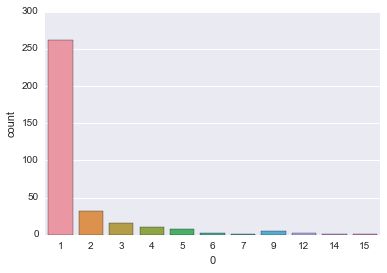

In [58]:
#Show frequency of how often hashtags appear 
sns.countplot(x = 0, data = hashtag_df.sort(0))
#most of the hashtags were only used once

In [59]:
#Create a second dataframe with the raw hashtag data
hashtagsraw_df = pd.DataFrame(hashtags)

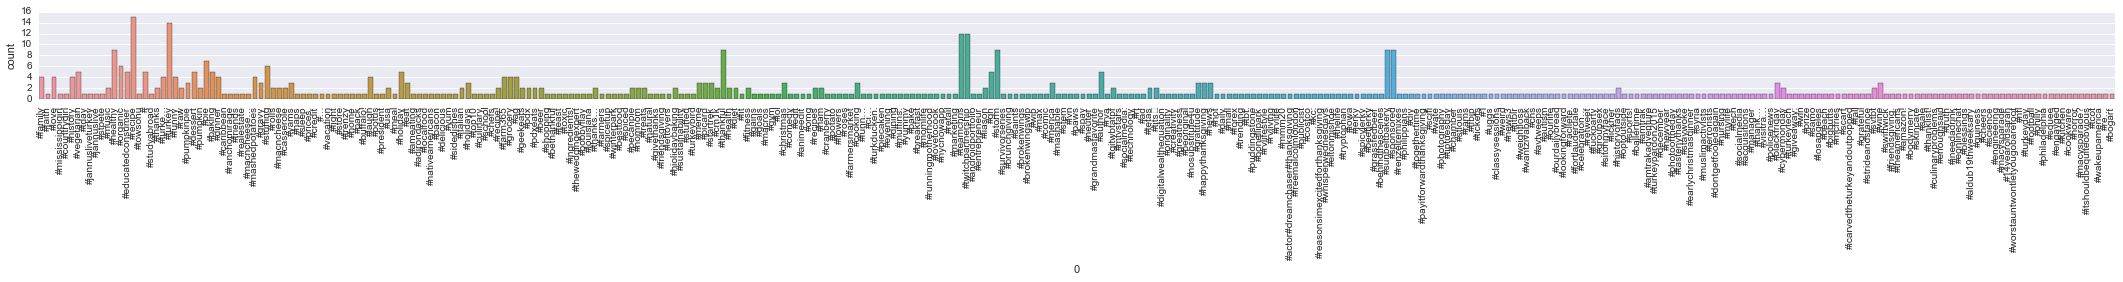

In [62]:
#Plot hashtags versus their frequencies
plt.figure(figsize=(30, 2))
sns.countplot(x = 0, data = hashtagsraw_df)
plt.tight_layout()
plt.xticks(rotation = 'vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
 <a list of 79 Text xticklabel objects>)

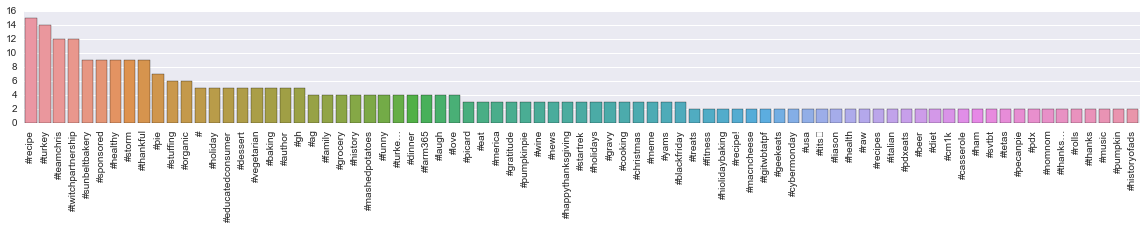

In [65]:
#Clearly too many values to read; get rid of hashtags that appear >1 time
hashtag_valuecount = pd.value_counts(hashtagsraw_df[0])
hashtag_valuecount = hashtag_valuecount[hashtag_valuecount>1]
plt.figure(figsize=(20,2))
sns.barplot(hashtag_valuecount.index, hashtag_valuecount.values)
plt.xticks(rotation = 'vertical')

Below are various functions I wrote for parsing in particular fields and dealing with errors

In [ ]:
def ignore_keyerrors(tweet):
    try:
        tweet['user']['location']
    except:
        return None
    return tweet['user']['location']


In [ ]:
def has_geo(tweet):
    try:
        tweet['geo']
    except:
        return False
    if tweet['geo'] is not None: 
        return tweet['geo']
    else:
        return False
    

In [ ]:
num = 0
for tweet in tweets_data:
        try:
            tweet['user']['location']
        except KeyError:
            num += 1
print(num)
            
    
        

In [ ]:
def has_coordinates(tweet):
    try:
        tweet['coordinates']
    except:
        return False
    if tweet['coordinates'] is not None: 
        return tweet['coordinates']
    else:
        return False

To do next: automate scraping at certain times of day. E.g. on the hour, for 5 minutes. See how the tweets change at different times of day